Establishing a connection with sqlite database

In [1]:
# import pandas as pd
# import sqlite3

In [2]:
# # def function to create connection to db
# def create_connection(db_file):
#     """
#     create a database connection to the SQLite database specified by db_file
#     :param df_file: database file
#     :return: Connection object or None
#     """
#     conn = None
#     try: 
#         conn = sqlite3.connect(db_file)
#         return conn
#     except 'Error' as e:
#         print(e)
        
#     return conn

In [3]:
# # create connection to db
# conn = create_connection('s3://sagemaker-studio-520298385440-7in8n1t299/dublinbus.db')

In [4]:
# # initialise query
# query = """
# SELECT leavetimes.*
# FROM leavetimes 
# WHERE TRIPID in  
#     (SELECT TRIPID
#     FROM trips
#     WHERE LINEID = '46A');
# """

In [5]:
# # execute query and read into dataframe
# query_df = pd.read_sql(query, conn)

# 1. Model Preperation

In [6]:
import boto3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm

from sagemaker import get_execution_role
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Connecting to s3
role = get_execution_role()
bucket='sagemaker-studio-520298385440-7in8n1t299'
data_key = 'route_46a.feather'
data_location = 's3://{}/{}'.format(bucket, data_key)

In [7]:
# Loading file
df = pd.read_feather(data_location)

## 1.1. Reviewing, splitting dataset into 7:3 for training and testing.

In [8]:
df.head(5)

,level_0,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
0,969,43824,2018-01-01,Monday,January,5955567,15,334,2868381,37920,37840,37920,37840,0,-48195,-48394,1,1
1,970,43825,2018-01-01,Monday,January,5955567,16,406,2868381,38117,37913,38117,37922,9,197,73,1,1
2,971,43826,2018-01-01,Monday,January,5955567,17,747,2868381,38226,37983,38226,37983,0,109,61,1,1
3,972,43827,2018-01-01,Monday,January,5955567,18,842,2868381,38326,38047,38326,38047,0,100,64,1,1
4,973,43828,2018-01-01,Monday,January,5955567,19,845,2868381,38391,38079,38391,38079,0,65,32,1,1


In [9]:
df.tail(5)

,level_0,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
4347782,4346354,116750045,2018-12-31,Monday,December,8590439,5,811,2868385,69850,69740,69850,69801,61,47,59,0,1
4347783,4346355,116750046,2018-12-31,Monday,December,8590439,6,812,2868385,69874,69821,69874,69821,0,24,20,0,1
4347784,4346356,116750047,2018-12-31,Monday,December,8590439,7,813,2868385,69901,69842,69901,69871,29,27,21,0,1
4347785,4346357,116750048,2018-12-31,Monday,December,8590439,8,814,2868385,70007,69914,70007,69914,0,106,43,0,1
4347786,4346358,116750049,2018-12-31,Monday,December,8590439,9,81,2868385,70099,70057,70099,70083,26,92,143,0,1


In [10]:
# Missing values
df.isnull().sum()

level_0               0
index                 0
DAYOFSERVICE          0
DAYOFWEEK             0
MONTHOFSERVICE        0
TRIPID                0
PROGRNUMBER           0
STOPPOINTID           0
VEHICLEID             0
PLANNEDTIME_ARR       0
ACTUALTIME_ARR        0
PLANNEDTIME_DEP       0
ACTUALTIME_DEP        0
DWELLTIME             0
PLANNEDTIME_TRAVEL    0
ACTUALTIME_TRAVEL     0
IS_HOLIDAY            0
IS_WEEKDAY            0
dtype: int64

In [11]:
# Unique types for each feature
df.nunique()

level_0               4347787
index                 4347787
DAYOFSERVICE              360
DAYOFWEEK                   7
MONTHOFSERVICE             12
TRIPID                  23279
PROGRNUMBER                65
STOPPOINTID               126
VEHICLEID                 320
PLANNEDTIME_ARR         65347
ACTUALTIME_ARR          68077
PLANNEDTIME_DEP         65347
ACTUALTIME_DEP          68069
DWELLTIME                1278
PLANNEDTIME_TRAVEL       9586
ACTUALTIME_TRAVEL       13880
IS_HOLIDAY                  2
IS_WEEKDAY                  2
dtype: int64

In [12]:
# Datatypes and convert
df.dtypes

level_0                        int64
index                          int64
DAYOFSERVICE          datetime64[ns]
DAYOFWEEK                     object
MONTHOFSERVICE                object
TRIPID                        object
PROGRNUMBER                   object
STOPPOINTID                   object
VEHICLEID                     object
PLANNEDTIME_ARR                int64
ACTUALTIME_ARR                 int64
PLANNEDTIME_DEP                int64
ACTUALTIME_DEP                 int64
DWELLTIME                      int64
PLANNEDTIME_TRAVEL             int64
ACTUALTIME_TRAVEL              int64
IS_HOLIDAY                    object
IS_WEEKDAY                    object
dtype: object

In [13]:
# Rows and columns
df.shape

(4347787, 18)

**Review so far:**
<br>
There are no more missing values and the constant columns have been removed.
* Remove index.
* Investigate level_0.
* Convert the following to categorical: DAYOFWEEK, MONTHOFSERVICE, PROGRNUMBER, STOPPOINTID, VEHICLEID, IS_HOLIDAY, IS_WEEKDAY.
* We have data for most of the days of the year and for each month.


In [14]:
df = df.drop(['level_0', 'index'], axis=1)

In [15]:
# Sorting by trip then dayofservice
df = df.sort_values(by=['TRIPID', 'DAYOFSERVICE'])

In [16]:
# Creating features
categorical_features = ['DAYOFWEEK', 'MONTHOFSERVICE', 'PROGRNUMBER', 'STOPPOINTID', 'VEHICLEID',
                       'TRIPID', 'IS_HOLIDAY', 'IS_WEEKDAY']

datetime_features = ['DAYOFSERVICE']

numerical_features = ['PLANNEDTIME_ARR', 'ACTUALTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_DEP',
                     'DWELLTIME', 'PLANNEDTIME_TRAVEL']

target_feat = 'ACTUALTIME_TRAVEL'

In [17]:
# Converting object to categorical
for column in categorical_features:
    df[column] = df[column].astype('category')

In [18]:
df.dtypes

DAYOFSERVICE          datetime64[ns]
DAYOFWEEK                   category
MONTHOFSERVICE              category
TRIPID                      category
PROGRNUMBER                 category
STOPPOINTID                 category
VEHICLEID                   category
PLANNEDTIME_ARR                int64
ACTUALTIME_ARR                 int64
PLANNEDTIME_DEP                int64
ACTUALTIME_DEP                 int64
DWELLTIME                      int64
PLANNEDTIME_TRAVEL             int64
ACTUALTIME_TRAVEL              int64
IS_HOLIDAY                  category
IS_WEEKDAY                  category
dtype: object

<br><br>
Setting the target feature as _y and x_ as the remaining features in the dataframe. 
<br><br>

In [19]:
df = df.sample(frac=1).reset_index(drop=True)

In [20]:
df.head(20)

,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
0,2018-08-28,Tuesday,August,7507841,11,818,1000584,82292,82259,82292,82259,0,29,10,0,1
1,2018-09-15,Saturday,September,8087728,62,805,2406879,52783,53561,52783,53561,0,68,54,0,0
2,2018-02-01,Thursday,February,6231952,18,842,1000290,27658,27670,27658,27688,18,100,68,0,1
3,2018-06-26,Tuesday,June,7103243,4,2042,1000293,25378,25341,25378,25341,0,72,48,0,1
4,2018-10-11,Thursday,October,8019560,15,334,2172246,27689,27552,27689,27649,97,159,153,0,1
5,2018-11-20,Tuesday,November,8119618,4,2042,1930279,67680,67691,67680,67691,0,96,49,0,1
6,2018-09-04,Tuesday,September,7649790,16,406,1000281,41807,41848,41807,41882,34,271,243,0,1
7,2018-04-13,Friday,April,6624602,10,4569,1000558,44960,45108,44960,45118,10,50,45,0,1
8,2018-05-03,Thursday,May,6649271,31,763,2693218,85596,85931,85596,85931,0,49,27,0,1
9,2018-04-01,Sunday,April,6584110,29,2084,1000275,51487,51079,51487,51121,42,53,88,0,0


In [21]:
# Creating y and x axis
target_feature = df['ACTUALTIME_TRAVEL']
y = pd.DataFrame(target_feature)
X = df.drop(['ACTUALTIME_TRAVEL'], axis=1)

# Splitting dataset for train and testing data by 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Printing shape of the new split data
print("The original range is: ",df.shape[0])
print("The training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("The test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

The original range is:  4347787
The training range (70%):	 rows 0 to 3043450
The test range (30%): 	 rows 3043450 to 4347787


In [22]:
X_train.head(5)

,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
2296641,2018-06-23,Saturday,June,7021652,28,2070,2534808,46815,46866,46815,46866,0,82,0,0
1261342,2018-01-10,Wednesday,January,6089104,39,777,1000578,75296,74985,75296,74985,0,45,0,1
2777787,2018-10-29,Monday,October,8065208,44,786,2172277,76027,75922,76027,75922,0,47,1,1
1107681,2018-10-25,Thursday,October,8060602,61,804,1000570,77130,77053,77130,77065,12,26,0,1
2419838,2018-06-20,Wednesday,June,7021537,61,804,1000572,52231,52988,52231,52988,0,35,0,1


## 1.2. Plot to compare all features to target feature to help make decisions to keep for the models.

#### Plotting datetime feature against target feature

In [23]:
# Plot datetime feature against target feature
X_train.DAYOFSERVICE = pd.to_numeric(X_train.DAYOFSERVICE)
df_temp = pd.concat([X_train['DAYOFSERVICE'], y_train], axis=1)
correlation_dt = df_temp[['DAYOFSERVICE', 'ACTUALTIME_TRAVEL']].corr(method='pearson')
correlation_dt

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,DAYOFSERVICE,ACTUALTIME_TRAVEL
DAYOFSERVICE,1.000000,0.000117
ACTUALTIME_TRAVEL,0.000117,1.000000


<AxesSubplot:xlabel='DAYOFSERVICE', ylabel='ACTUALTIME_TRAVEL'>

<Figure size 432x288 with 0 Axes>

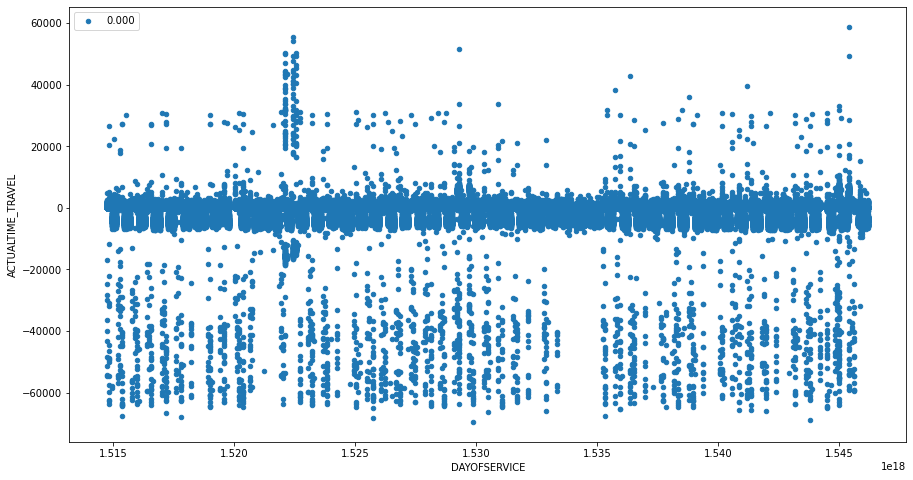

In [24]:
fig = plt.figure()
ax = fig.add_subplot
df_temp.plot(kind='scatter', x='DAYOFSERVICE', y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', 'DAYOFSERVICE']].corr().to_numpy()[0,1], figsize=(15, 8)) 

#### Plotting numerical features against target feature

In [26]:
# # Plot numerical features against target feature

# sns.set(style='white')

# # Calculating the correlation of all pairs of the numerical features
# corr = X_train[numerical_features].corr()

# # Generating a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# # Set up matplotlib figure
# f, ax = plt.subplots(figsize=(20,20))

# # Generating a custome color map
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
#             square=True, xticklabels=True, yticklabels=True,
#             linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
# plt.yticks(rotation = 0)
# plt.xticks(rotation = 90)

In [27]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    correlation_dt = df_temp[[column, 'ACTUALTIME_TRAVEL']].corr(method='pearson')
    print('\n',correlation_dt)


                    PLANNEDTIME_ARR  ACTUALTIME_TRAVEL
PLANNEDTIME_ARR           1.000000           0.039001
ACTUALTIME_TRAVEL         0.039001           1.000000

                    ACTUALTIME_ARR  ACTUALTIME_TRAVEL
ACTUALTIME_ARR           1.000000           0.039661
ACTUALTIME_TRAVEL        0.039661           1.000000

                    PLANNEDTIME_DEP  ACTUALTIME_TRAVEL
PLANNEDTIME_DEP           1.000000           0.039001
ACTUALTIME_TRAVEL         0.039001           1.000000

                    ACTUALTIME_DEP  ACTUALTIME_TRAVEL
ACTUALTIME_DEP           1.000000           0.039731
ACTUALTIME_TRAVEL        0.039731           1.000000

                    DWELLTIME  ACTUALTIME_TRAVEL
DWELLTIME           1.000000           0.036305
ACTUALTIME_TRAVEL   0.036305           1.000000

                     PLANNEDTIME_TRAVEL  ACTUALTIME_TRAVEL
PLANNEDTIME_TRAVEL            1.000000           0.996344
ACTUALTIME_TRAVEL             0.996344           1.000000


In [28]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    correlation_dt = df_temp[[column, 'ACTUALTIME_TRAVEL']].corr(method='spearman')
    print('\n',correlation_dt)


                    PLANNEDTIME_ARR  ACTUALTIME_TRAVEL
PLANNEDTIME_ARR           1.000000          -0.050201
ACTUALTIME_TRAVEL        -0.050201           1.000000

                    ACTUALTIME_ARR  ACTUALTIME_TRAVEL
ACTUALTIME_ARR           1.000000          -0.048431
ACTUALTIME_TRAVEL       -0.048431           1.000000

                    PLANNEDTIME_DEP  ACTUALTIME_TRAVEL
PLANNEDTIME_DEP           1.000000          -0.050201
ACTUALTIME_TRAVEL        -0.050201           1.000000

                    ACTUALTIME_DEP  ACTUALTIME_TRAVEL
ACTUALTIME_DEP           1.000000          -0.048075
ACTUALTIME_TRAVEL       -0.048075           1.000000

                    DWELLTIME  ACTUALTIME_TRAVEL
DWELLTIME            1.00000            0.33513
ACTUALTIME_TRAVEL    0.33513            1.00000

                     PLANNEDTIME_TRAVEL  ACTUALTIME_TRAVEL
PLANNEDTIME_TRAVEL            1.000000           0.772477
ACTUALTIME_TRAVEL             0.772477           1.000000


<Figure size 432x288 with 0 Axes>

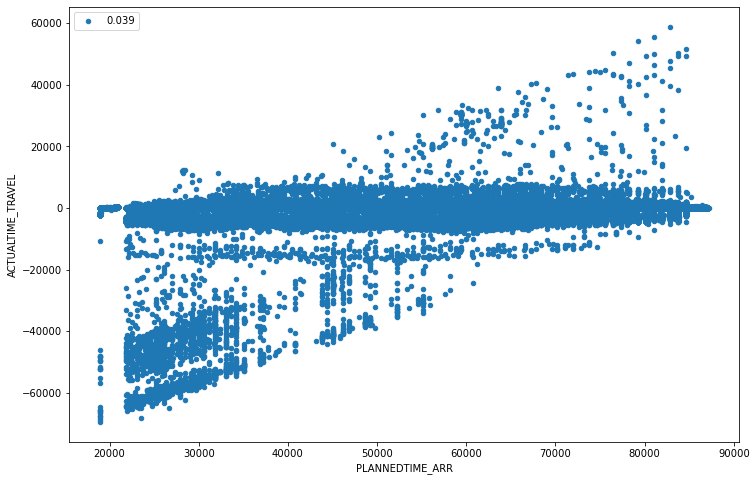

<Figure size 432x288 with 0 Axes>

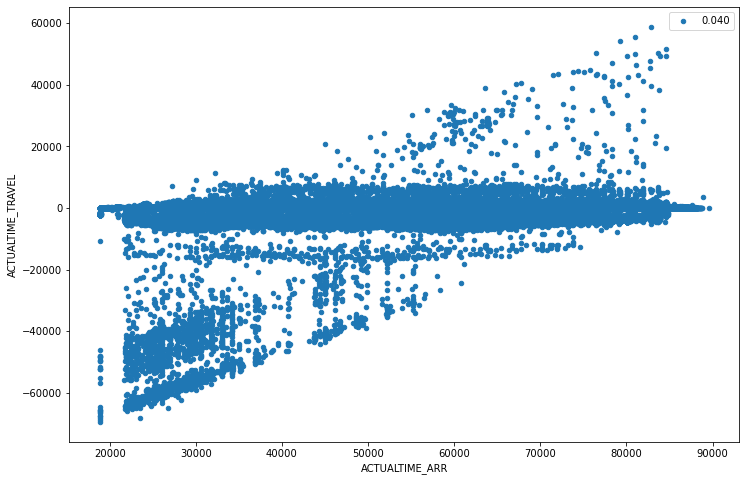

<Figure size 432x288 with 0 Axes>

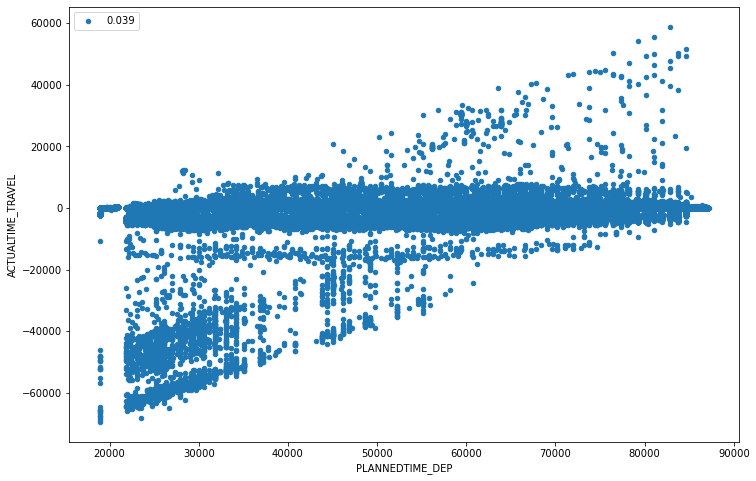

<Figure size 432x288 with 0 Axes>

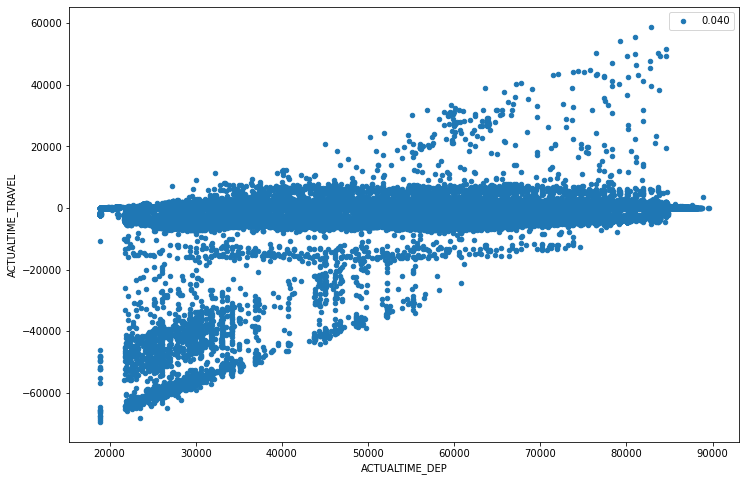

<Figure size 432x288 with 0 Axes>

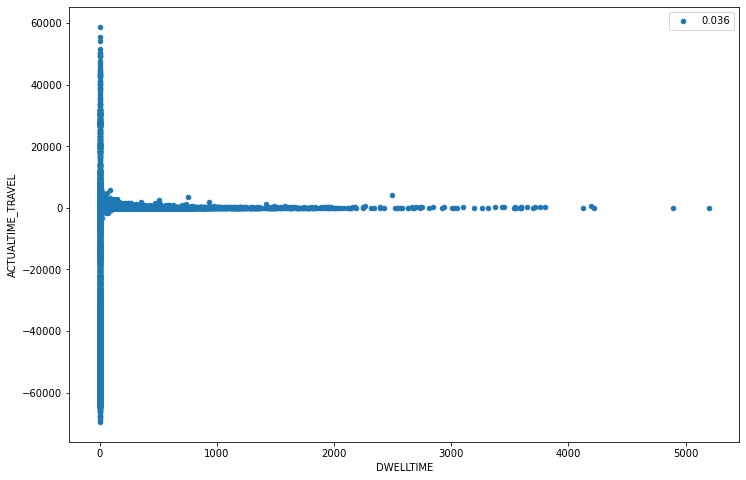

<Figure size 432x288 with 0 Axes>

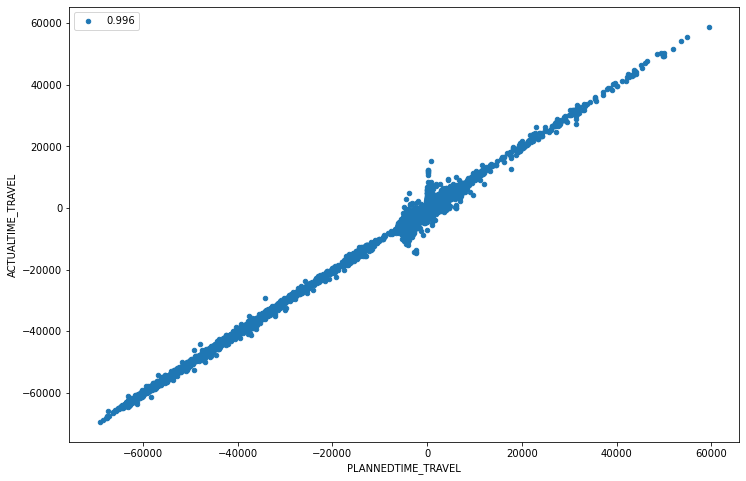

In [29]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='pearson').to_numpy()[0,1], figsize=(12, 8)) 

<Figure size 432x288 with 0 Axes>

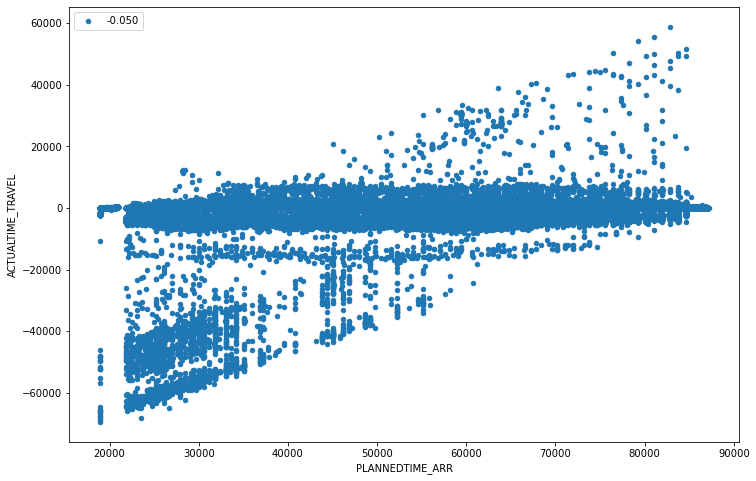

<Figure size 432x288 with 0 Axes>

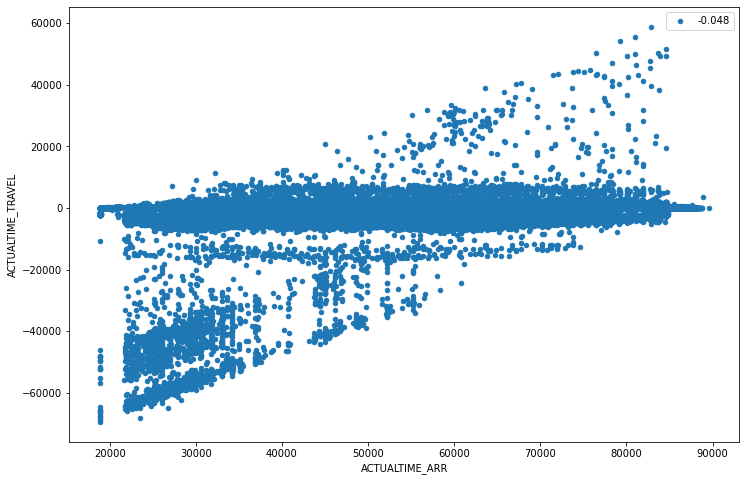

<Figure size 432x288 with 0 Axes>

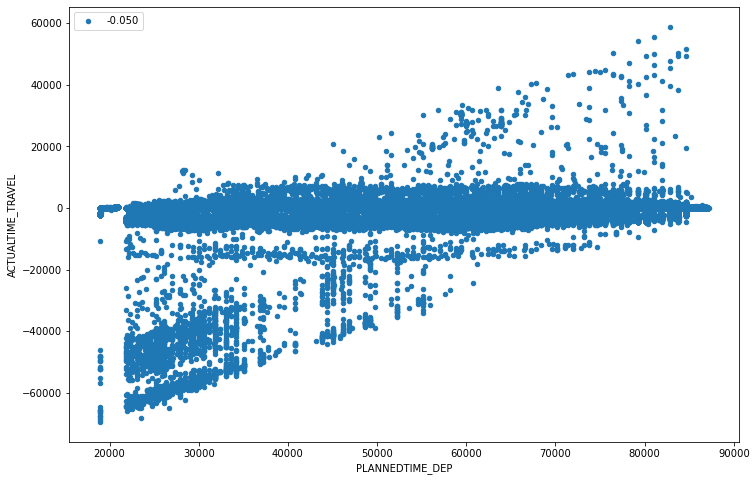

<Figure size 432x288 with 0 Axes>

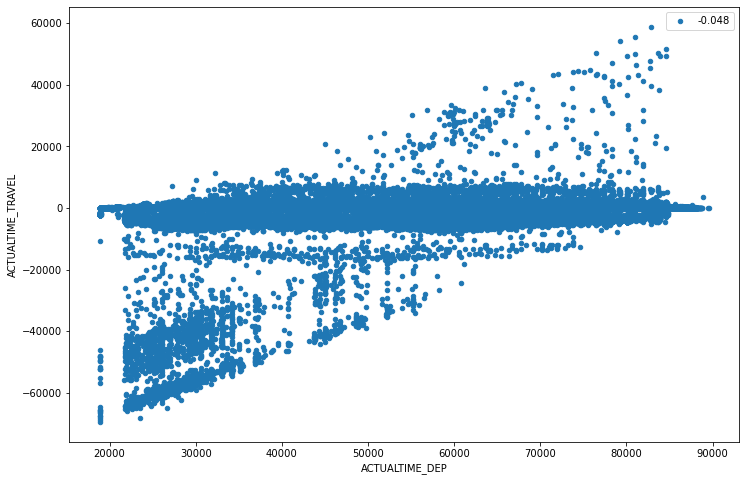

<Figure size 432x288 with 0 Axes>

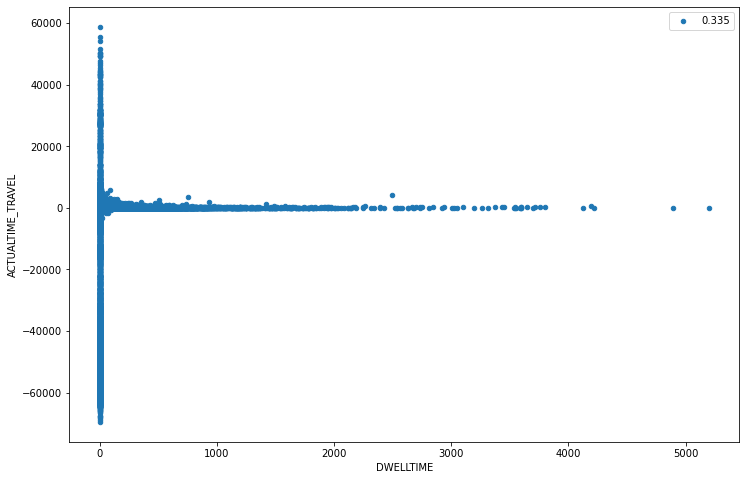

<Figure size 432x288 with 0 Axes>

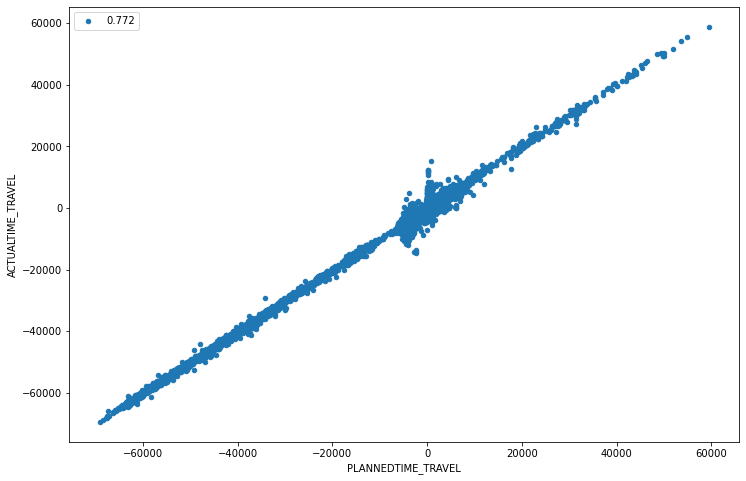

In [30]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='spearman').to_numpy()[0,1], figsize=(12, 8)) 

#### Plotting categorical features against target feature

In [ ]:
# Plot categorical features against target feature

df_temp = pd.concat([X_train, y_train], axis=1)

for feature in categorical_features:
    
    # Creating a hash table and return as an array
    categ_feat = pd.unique(df_temp[feature].ravel())
    df_temp['percent'] = 0
    
    print("\n", feature)
    print("Index \t\t Count")
    
    for column in categ_feat:
        
        count = df_temp[df_temp[feature] == column].count()['ACTUALTIME_TRAVEL']
        count_percentage = (1/count) * 100
        print(column, "\t", count)
        
        index = df_temp[df_temp[feature] == column].index.tolist()
        for ind in index:
            df_temp.loc[ind, 'percent'] = count_percentage
            
    grouped = df_temp[['percent', feature, 'ACTUALTIME_TRAVEL']].groupby([feature, 'ACTUALTIME_TRAVEL']).sum()
    plot = grouped.unstack().plot(kind='bar', stacked=True, title=f' ACTUALTIME_TRAVEL v {feature}',
                                 figsize=(10,5), grid=True)
    
    # Adding legends, gridlines, labels
    red = mpatches.Patch(color='red', label='Yes')
    blue = mpatches.Patch(color='blue', label='No')
    plot.legend(handles=[red, blue], frameon=True)
    
    plt.grid(b=True, which='minor', color='#666666', linestyle='-')
    plt.minortricks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plot.set_xlabel("---")
    plot.set_ylabel("% Death")
    plot.set_ylim([0,100])
    
    
# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop("percent", 1)